In [1]:
import os
import random
import shutil
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, DenseNet121

# Suppress warnings
warnings.filterwarnings('ignore')


In [90]:

train_dir = r"H:\Semester 1\Big Data & AI\Personal Projects\Hand Sign\train_images"
test_dir = r"H:\Semester 1\Big Data & AI\Personal Projects\Hand Sign\test_images"


seed_value = 30
img_height, img_width = 56, 56
batch_size = 24

train_datagen = ImageDataGenerator(rescale=1./255,              # Normalize pixel values from [0, 255] to [0, 1] for faster and more stable training
                                   rotation_range=20,           # Randomly rotate images up to 40 degrees to simulate different orientations of dogs and cats
                                   width_shift_range=0.2,       # Shift images horizontally by up to 20% of the width to make the model robust to object position
                                   height_shift_range=0.2,      # Shift images vertically by up to 20% of the height for similar spatial robustness
                                   shear_range=0.2,             # Apply shearing transformations (like slanting) to simulate perspective changes
                                   zoom_range=0.3,              # Randomly zoom in/out by up to 20% to help the model handle different scales of animals
                                   horizontal_flip=True,        # Randomly flip images horizontally — essential for recognizing left/right facing dogs and cats
                                   fill_mode='nearest')         # Fill in empty pixels created by transformations using the nearest pixel values to avoid artifacts   # Randomly zoom in/out by up to 20% to help the model handle different scales of animals
       
test_datagen = ImageDataGenerator(rescale=1./255        )         # Fill in empty pixels created by transformations using the nearest pixel values to avoid artifacts   # Randomly zoom in/out by up to 20% to help the model handle different scales of animals
       

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    seed=seed_value,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  seed=seed_value,
                                                  class_mode='categorical',
                                                  shuffle=False 
                                                  )

Found 8740 images belonging to 8 classes.
Found 2847 images belonging to 8 classes.


Checking the weight of the classes

In [91]:
labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.9702486678507993), 1: np.float64(1.0816831683168318), 2: np.float64(0.9549825174825175), 3: np.float64(0.9134615384615384), 4: np.float64(1.1415882967607105), 5: np.float64(0.907392026578073), 6: np.float64(1.0022935779816513), 7: np.float64(1.0784797630799605)}


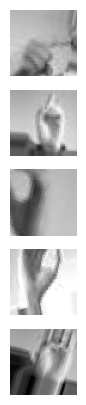

In [107]:
# Display sample images
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 1))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()


# Plot sample images
sample_training_images, _ = next(train_generator)

plotImages(sample_training_images[:5])

In [108]:
# Number of samples and classes
classes = list(train_generator.class_indices.keys())
num_classes = len(classes)
print('Classes:', classes)
print(num_classes)


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
8


In [109]:
print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}


In [110]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    class_weight=class_weight_dict   
)


test_loss, test_acc = model.evaluate(test_generator, verbose=2)

Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 51s 130ms/step - accuracy: 0.4294 - loss: 1.6794 - val_accuracy: 0.3628 - val_loss: 2.7339
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.6590 - loss: 0.9077 - val_accuracy: 0.7636 - val_loss: 0.5464
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.7477 - loss: 0.6573 - val_accuracy: 0.7808 - val_loss: 0.7102
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8057 - loss: 0.5202 - val_accuracy: 0.5933 - val_loss: 1.4734
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8396 - loss: 0.4352 - val_accuracy: 0.8950 - val_loss: 0.3106
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8827 - loss: 0.3298 - val_accuracy: 0.9796 - val_loss: 0.0829
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8902 - loss: 0.3124 - val_accuracy: 0.7604 - val_loss: 0.6864
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8951 - loss: 0.3180 

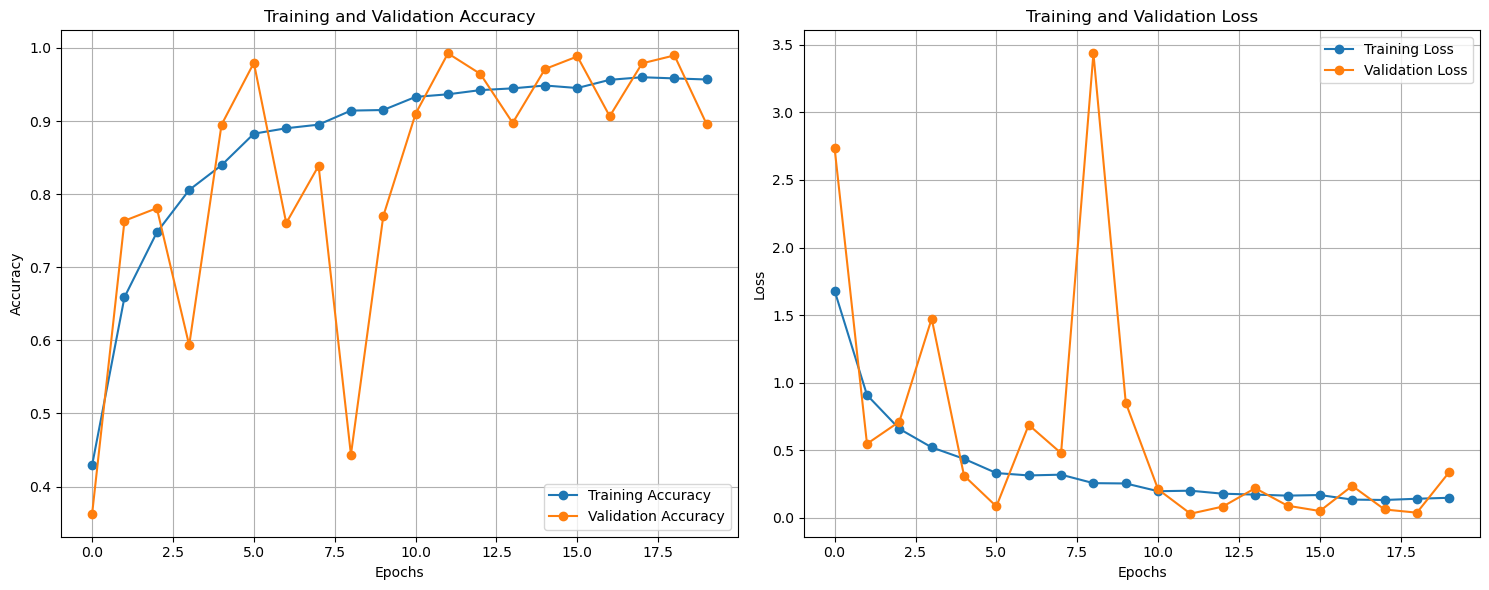

In [111]:
# Accuracy and Loss Curves
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(15, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)


In [112]:
# Prediction
true_class = test_generator.classes
predictions = model.predict(test_generator)
predicted_class = np.argmax(predictions, axis=1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

✅ Model Accuracy: 0.8953

📉 Confusion Matrix:
[[263   0  10   0   5   0   2  51]
 [  0 401   0   0   1   0   5  25]
 [  0   0 308   0   0   0   2   0]
 [  0   0   4 194   4   4  24  15]
 [  0   0   7   0 468   0  12  11]
 [  0   0   4   0   0 235   8   0]
 [  0   0   0   0   0   0 344   4]
 [  0   0   0   0   0   0 100 336]]

📋 Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.79      0.89       331
           B       1.00      0.93      0.96       432
           C       0.92      0.99      0.96       310
           D       1.00      0.79      0.88       245
           E       0.98      0.94      0.96       498
           F       0.98      0.95      0.97       247
           G       0.69      0.99      0.81       348
           H       0.76      0.77      0.77       436

    accuracy                           0.90      2847
   macro avg       0.82      0.80      0.80      2847
weighted

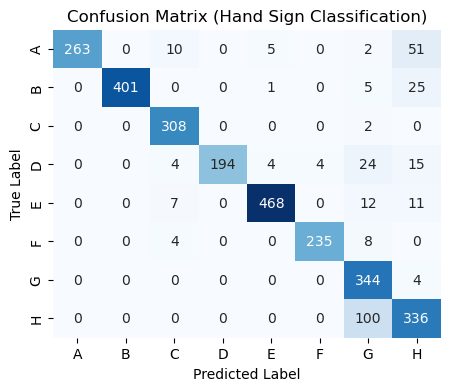

In [113]:
# Prediction
true_class = test_generator.classes
predictions = model.predict(test_generator)
predicted_class = np.argmax(predictions, axis=1)



# Model performance metrics
accuracy = accuracy_score(true_class, predicted_class)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_class, predicted_class, average='weighted')
conf_matrix = confusion_matrix(true_class, predicted_class)
class_report = classification_report(true_class, predicted_class, 
                                     labels=[0, 1, 2, 3, 4, 5, 6, 7, 8],   
                                     target_names=["A", "B", "C", "D", "E", "F", "G", "H"])

# Display the evaluation metrics
print(f"\n✅ Model Accuracy: {accuracy:.4f}")
print(f"\n📉 Confusion Matrix:\n{conf_matrix}")
print(f"\n📋 Classification Report:\n{class_report}")

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["A", "B", "C", "D", "E", "F", "G", "H"],
            yticklabels=["A", "B", "C", "D", "E", "F", "G", "H"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Hand Sign Classification)")
plt.show()

In [114]:
print(model.input_shape)

(None, 56, 56, 3)


In [117]:

base_model = ResNet50(
    weights='imagenet',      
    include_top=False,      
    input_shape=(img_height, img_width, 3)
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
predictions = layers.Dense(8, activation='softmax')(x)  # 4 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    class_weight=class_weight_dict
)


test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 54s 129ms/step - accuracy: 0.1273 - loss: 2.1230 - val_accuracy: 0.1858 - val_loss: 2.0791
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.1487 - loss: 2.0807 - val_accuracy: 0.2136 - val_loss: 2.0455
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.1729 - loss: 2.0614 - val_accuracy: 0.2771 - val_loss: 2.0340
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 47s 129ms/step - accuracy: 0.1955 - loss: 2.0435 - val_accuracy: 0.2532 - val_loss: 2.0254
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.2287 - loss: 2.0307 - val_accuracy: 0.2508 - val_loss: 2.0045
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - accuracy: 0.2411 - loss: 2.0165 - val_accuracy: 0.2940 - val_loss: 1.9822
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 50s 136ms/step - accuracy: 0.2418 - loss: 2.0032 - val_accuracy: 0.3375 - val_loss: 1.9624
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 48s 133ms/step - accuracy: 0.2511 - loss: 1

119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step

✅ Model Accuracy: 0.4542

📉 Confusion Matrix:
[[ 14  55  17  27   6  11  30 171]
 [  0 329   0  21  21  43   0  18]
 [  0   2 264   0   7  21  16   0]
 [  0  39   5  87   0  38   2  74]
 [ 15 202  24  25  54 104   1  73]
 [ 13  84  28  11   0 104   7   0]
 [  0   8  39  38   0  12 105 146]
 [  0   0   7   0   0   0  93 336]]

📋 Classification Report:
              precision    recall  f1-score   support

           A       0.33      0.04      0.08       331
           B       0.46      0.76      0.57       432
           C       0.69      0.85      0.76       310
           D       0.42      0.36      0.38       245
           E       0.61      0.11      0.18       498
           F       0.31      0.42      0.36       247
           G       0.41      0.30      0.35       348
           H       0.41      0.77      0.54       436

    accuracy                           0.45      2847
   macro avg       0.40      0.40      0.36      2847
weighte

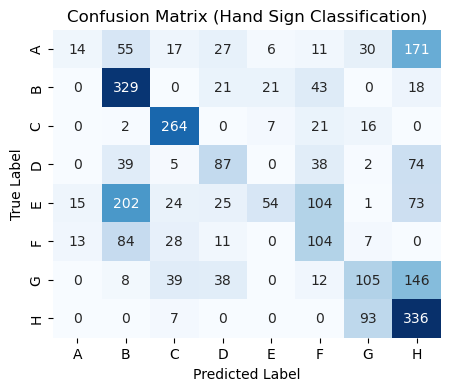

In [118]:
# Prediction
true_class = test_generator.classes
predictions = model.predict(test_generator)
predicted_class = np.argmax(predictions, axis=1)



# Model performance metrics
accuracy = accuracy_score(true_class, predicted_class)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_class, predicted_class, average='weighted')
conf_matrix = confusion_matrix(true_class, predicted_class)
class_report = classification_report(true_class, predicted_class, 
                                     labels=[0, 1, 2, 3, 4, 5, 6, 7, 8],   
                                     target_names=["A", "B", "C", "D", "E", "F", "G", "H"])

# Display the evaluation metrics
print(f"\n✅ Model Accuracy: {accuracy:.4f}")
print(f"\n📉 Confusion Matrix:\n{conf_matrix}")
print(f"\n📋 Classification Report:\n{class_report}")

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["A", "B", "C", "D", "E", "F", "G", "H"],
            yticklabels=["A", "B", "C", "D", "E", "F", "G", "H"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Hand Sign Classification)")
plt.show()

In [119]:

base_model = MobileNetV2(
    weights='imagenet',    
    include_top=False,       
    input_shape=(img_height, img_width, 3)
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(8, activation='softmax')(x)  # 4 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    class_weight=class_weight_dict
)

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.4152 - loss: 1.6542 - val_accuracy: 0.7580 - val_loss: 0.8421
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.6232 - loss: 1.0682 - val_accuracy: 0.7868 - val_loss: 0.6714
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.6841 - loss: 0.8837 - val_accuracy: 0.8223 - val_loss: 0.5812
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7238 - loss: 0.7923 - val_accuracy: 0.8282 - val_loss: 0.5332
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7452 - loss: 0.7120 - val_accuracy: 0.8409 - val_loss: 0.4919
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7630 - loss: 0.6614 - val_accuracy: 0.8472 - val_loss: 0.4925
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7720 - loss: 0.6327 - val_accuracy: 0.8476 - val_loss: 0.4481
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7847 - loss: 0.5950 - 

119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step

✅ Model Accuracy: 0.8890

📉 Confusion Matrix:
[[310   0   0   0  21   0   0   0]
 [  0 363   0   7  62   0   0   0]
 [  0   0 281   2  12   2   5   8]
 [  0  11   0 223   2   8   1   0]
 [  0   1   0   1 495   0   0   1]
 [  4  16   0  16  16 195   0   0]
 [  0   0   1   0   0   0 269  78]
 [  3   1   4   0   7   0  26 395]]

📋 Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.94      0.96       331
           B       0.93      0.84      0.88       432
           C       0.98      0.91      0.94       310
           D       0.90      0.91      0.90       245
           E       0.80      0.99      0.89       498
           F       0.95      0.79      0.86       247
           G       0.89      0.77      0.83       348
           H       0.82      0.91      0.86       436

    accuracy                           0.89      2847
   macro avg       0.81      0.78      0.79      2847
weighted

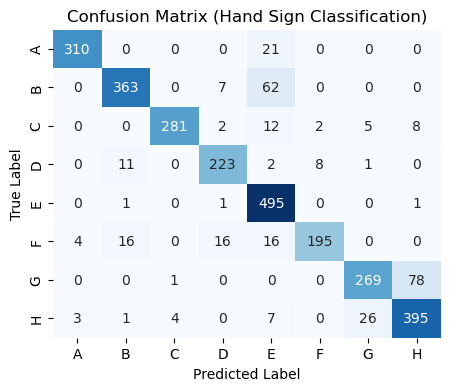

In [120]:
# Prediction
true_class = test_generator.classes
predictions = model.predict(test_generator)
predicted_class = np.argmax(predictions, axis=1)



# Model performance metrics
accuracy = accuracy_score(true_class, predicted_class)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_class, predicted_class, average='weighted')
conf_matrix = confusion_matrix(true_class, predicted_class)
class_report = classification_report(true_class, predicted_class, 
                                     labels=[0, 1, 2, 3, 4, 5, 6, 7, 8],   
                                     target_names=["A", "B", "C", "D", "E", "F", "G", "H"])

# Display the evaluation metrics
print(f"\n✅ Model Accuracy: {accuracy:.4f}")
print(f"\n📉 Confusion Matrix:\n{conf_matrix}")
print(f"\n📋 Classification Report:\n{class_report}")

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["A", "B", "C", "D", "E", "F", "G", "H"],
            yticklabels=["A", "B", "C", "D", "E", "F", "G", "H"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Hand Sign Classification)")
plt.show()

In [121]:

base_model = DenseNet121(
    weights='imagenet',      
    include_top=False,      
    input_shape=(img_height, img_width, 3)
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(8, activation='softmax')(x)  # 4 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    class_weight=class_weight_dict
)

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - accuracy: 0.3822 - loss: 1.6771 - val_accuracy: 0.7250 - val_loss: 1.1163
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.6127 - loss: 1.1169 - val_accuracy: 0.8128 - val_loss: 0.8006
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.6908 - loss: 0.9019 - val_accuracy: 0.8620 - val_loss: 0.6439
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.7309 - loss: 0.7837 - val_accuracy: 0.8872 - val_loss: 0.5429
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.7580 - loss: 0.7057 - val_accuracy: 0.8925 - val_loss: 0.4842
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.7780 - loss: 0.6424 - val_accuracy: 0.8880 - val_loss: 0.4442
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.7850 - loss: 0.6238 - val_accuracy: 0.8992 - val_loss: 0.4044
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.8092 - loss: 0.5734 - 

119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step

✅ Model Accuracy: 0.9262

📉 Confusion Matrix:
[[298   1   0   0  32   0   0   0]
 [  3 427   0   2   0   0   0   0]
 [  0   0 310   0   0   0   0   0]
 [  0   0   0 233  12   0   0   0]
 [  0   0   0   0 497   0   1   0]
 [  0   0   0   2   0 245   0   0]
 [  0   0   0   0   1   0 227 120]
 [  0   0   0   0   0   0  36 400]]

📋 Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.90      0.94       331
           B       1.00      0.99      0.99       432
           C       1.00      1.00      1.00       310
           D       0.98      0.95      0.97       245
           E       0.92      1.00      0.96       498
           F       1.00      0.99      1.00       247
           G       0.86      0.65      0.74       348
           H       0.77      0.92      0.84       436

    accuracy                           0.93      2847
   macro avg       0.84      0.82      0.83      2847
weight

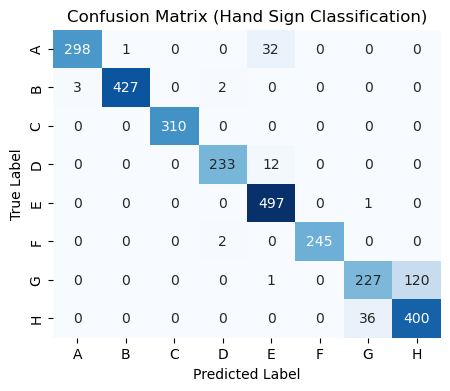

In [122]:
# Prediction
true_class = test_generator.classes
predictions = model.predict(test_generator)
predicted_class = np.argmax(predictions, axis=1)



# Model performance metrics
accuracy = accuracy_score(true_class, predicted_class)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_class, predicted_class, average='weighted')
conf_matrix = confusion_matrix(true_class, predicted_class)
class_report = classification_report(true_class, predicted_class, 
                                     labels=[0, 1, 2, 3, 4, 5, 6, 7, 8],   
                                     target_names=["A", "B", "C", "D", "E", "F", "G", "H"])

# Display the evaluation metrics
print(f"\n✅ Model Accuracy: {accuracy:.4f}")
print(f"\n📉 Confusion Matrix:\n{conf_matrix}")
print(f"\n📋 Classification Report:\n{class_report}")

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["A", "B", "C", "D", "E", "F", "G", "H"],
            yticklabels=["A", "B", "C", "D", "E", "F", "G", "H"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Hand Sign Classification)")
plt.show()